# 0. Useful libraries

In [1]:
from imports import *
from utils import *
from diffusion_model import *

# 1. Explore datasets

## 1.1. Time-series

For both 1D and 3D turbulent velocity trajectories, we plot a sample time series:

In [2]:
# File of 1D turbulent velocity trajectories
file_1d = 'Lagr_u1c_diffusion-demo.h5'

# Fetch the file
velocities_1d = file_loader(file_1d)

# Plot the time series of the 1st 1D trajectory
sample_1d = velocities_1d[0]
plot_time_series(sample_1d)

Keys of the file Lagr_u1c_diffusion-demo.h5 : ['max', 'min', 'train']
    min value : -11.244815117091042
    max value : 10.314160931635518
    data shape : (n_samples, n_timesteps, n_dimensions) = (768, 2000, 1)


- The velocity component fluctuates around zero and shows variations within different time scales.
- The strong non-Gaussian fluctuations (intermittency) observed between the 400th and 550th timesteps are characteristic of turbulent dynamics and are often associated with localized vortical structures and enhanced small-scale dissipation.

In [3]:
# Name of the 3D turbulent velocity trajectories
file_3d = 'Lagr_u3c_diffusion-demo.h5'

# Fetch the file
velocities_3d = file_loader(file_3d)

# Plot the time-series of the 1st 3D trajectory
sample_3d = velocities_3d[0]
plot_time_series(sample_3d)

Keys of the file Lagr_u3c_diffusion-demo.h5 : ['max', 'min', 'train']
    min value : [ -9.97037474 -11.24481512  -9.49838034]
    max value : [10.27369886 10.31416093 10.19539748]
    data shape : (n_samples, n_timesteps, n_dimensions) = (256, 2000, 3)


- Similarly to 1D trajectory, three standardized velocity components (V1, V2, V3) fluctuate strongly around zero, illustrating the stochastic and oscillatory nature of turbulence.
- The high oscillatory correlations between the three components are consistent with the presence of strong vortical structures.

Note that the 1D velocity data are equivalent to the 3D velocity data, except that the different components are stacked along the same dimension. Therefore, we can restrict our exploratory analysis to the 1D velocity data.

## 1.2. Probability density function (PDF) of velocity increments

In [4]:
tau_values = [10,50,1000]
plot_pdf_increments(velocities_3d, tau_values)

For 3 dimension(s), each dimension has 509440 samples of velocity increments at τ = 10.
For 3 dimension(s), each dimension has 499200 samples of velocity increments at τ = 50.
For 3 dimension(s), each dimension has 256000 samples of velocity increments at τ = 1000.


The PDFs of velocity increments deviate strongly from a Gaussian shape. They exhibit heavy tails and sharp peaks that become more pronounced at smaller time lags τ, reflecting the dominance of small-scale intermittent events in turbulent dynamics.

# 2. Diffusion model : forward noising process

The forward noising process starts from the ground-truth trajectory $\mathcal{V}_0$ = $\mathcal{V}$ and transforms it, after N steps, to a trajectory identical to pure random Gaussian noise. So, This process generates trajectories $\mathcal{V}_1,…,\mathcal{V}_N$, whose joint distribution can be simplified using the Markov property :

$$
q(\mathcal{V}_{1:N} \mid \mathcal{V}_0) := \prod_{n=1}^{N} q(\mathcal{V}_n \mid \mathcal{V}_{n-1})
$$

For each diffusion step n, the trajectory $\mathcal{V}_n$ progressively add Gaussian noise to the previous trajectory $\mathcal{V}_{n-1}$ with a variance $\mathcal{\beta}_n$ ∈ (0, 1) according to the following formulation :
$$
q(\mathcal{V}_n \mid \mathcal{V}_{n-1}) = \mathcal{N}\Big(\sqrt{1-\beta_n}\,\mathcal{V}_{n-1}, \; \beta_n I\Big)
$$

We can show that, for any given diffusion step n and ground-truth trajectory $\mathcal{V}_0$, the trajectory $\mathcal{V}_n$ can be determined in a closed form by defining $\alpha_n := 1 - \beta_n$ and $\bar{\alpha}_n := \prod_{i=1}^{n} \alpha_i$
$$
q(\mathcal{V}_n \mid \mathcal{V}_0) = \mathcal{N}\Big(\sqrt{\bar{\alpha}_n}\,\mathcal{V}_0, \; (1-\bar{\alpha}_n) I\Big)
$$

Therefore, the forward noising process is fully determined by the choice of the variance schedule $\mathcal{\beta}_{1:N}$, defining simultaneously the sequence $\bar{\alpha}_{1:N}$ which quantifies how much of the initial trajectory is preserved at each step $\mathcal{n}$. Factors such as the number of diffusion steps N and the choice of the noise schedule influence the speed and manner in which the transformation occurs.

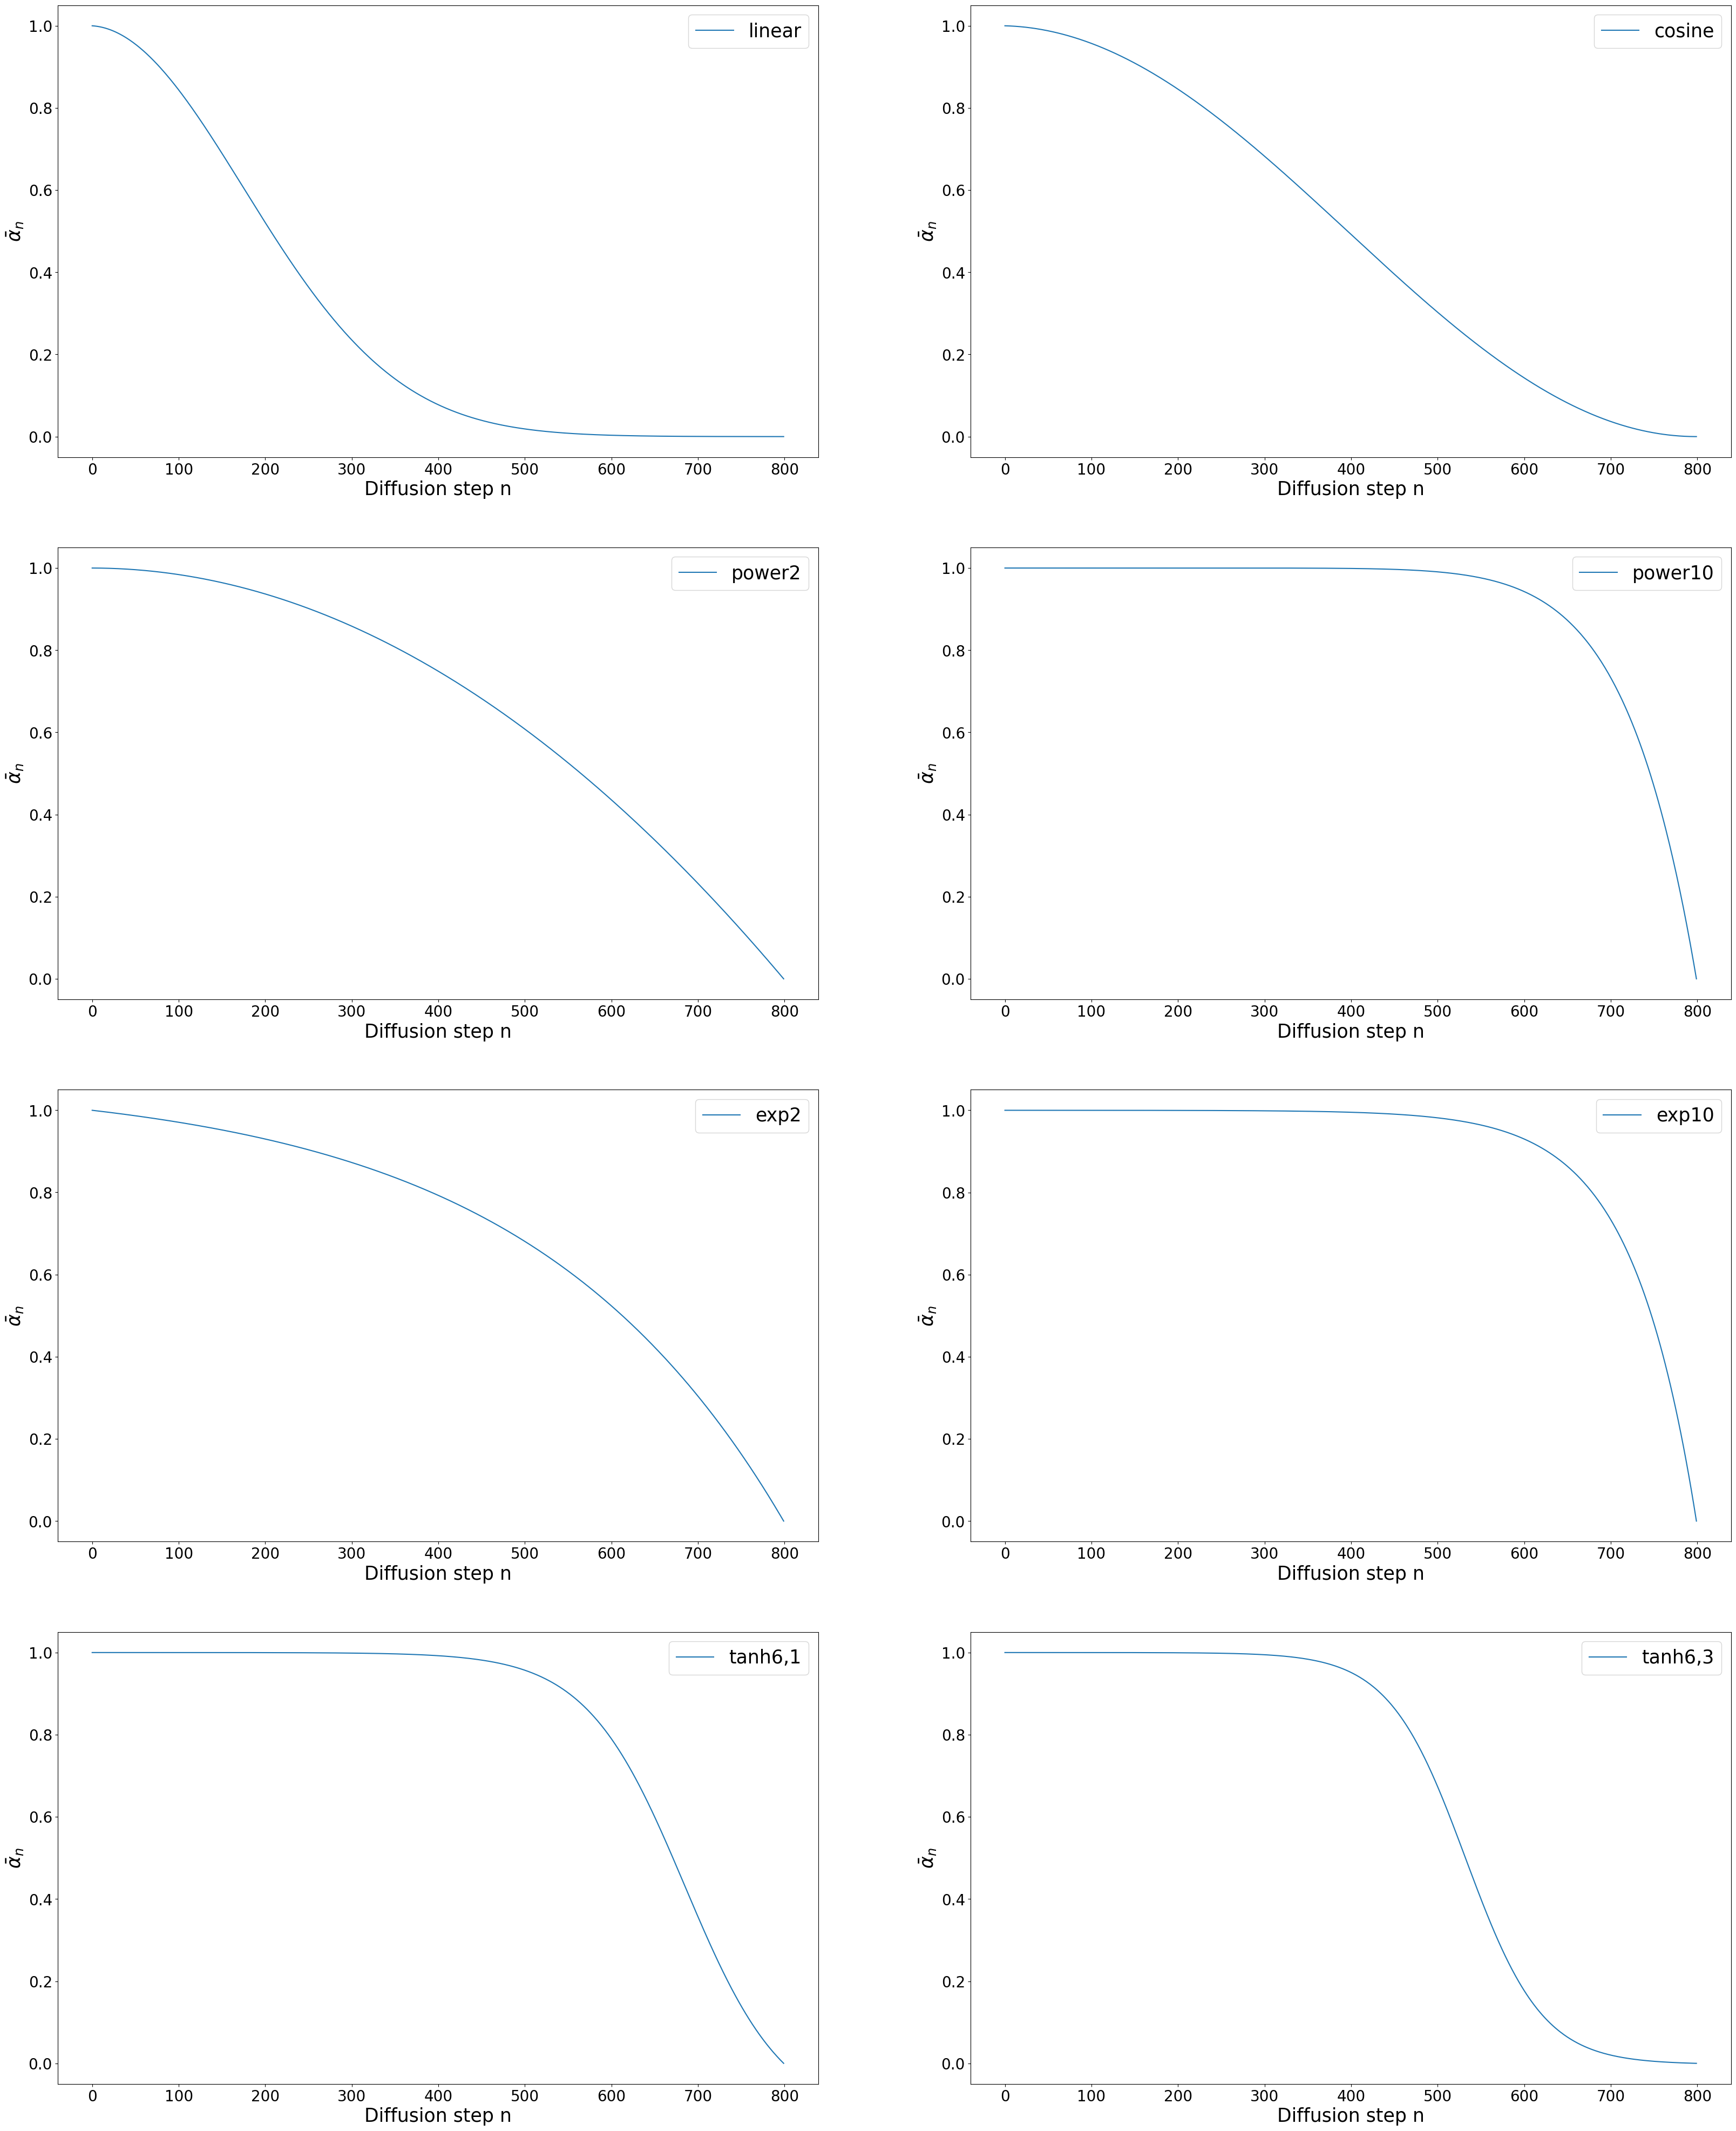

In [62]:
N = 800

# Noise schedules
noise_schedules = ['linear', 'cosine', 'power2', 'power10', 'exp2', 'exp10', 'tanh6,1', 'tanh6,3']

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(40,50))
axes = axes.flatten()

for (i,schedule) in enumerate(noise_schedules):
    betas = get_named_beta_schedule(schedule, N)
    alpha_bar = alpha_bar_from_betas(betas)
    sns.lineplot(x = np.arange(N),
                 y = alpha_bar,
                 ax = axes[i],
                 label = schedule)
    axes[i].set_xlabel('Diffusion step n', fontsize=25)
    axes[i].set_ylabel(r'$\bar{\alpha}_n$', fontsize=25)
    axes[i].tick_params('x', labelsize=20)
    axes[i].tick_params('y', labelsize=20)
    axes[i].legend(fontsize=25)

- Every $\bar{\alpha}_{1:N}$ sequence progressively decreases from 1 to 0, reflecting the gradual reduction of the preserved proportion of the initial trajectory across the diffusion steps.

- The documentation paper mentions that the optimal noise schedule tested is tanh6-1.

For 1 dimension(s), each dimension has 1990 samples of velocity increments at τ = 10.
For 1 dimension(s), each dimension has 1990 samples of velocity increments at τ = 10.
For 1 dimension(s), each dimension has 1990 samples of velocity increments at τ = 10.
For 1 dimension(s), each dimension has 1990 samples of velocity increments at τ = 10.


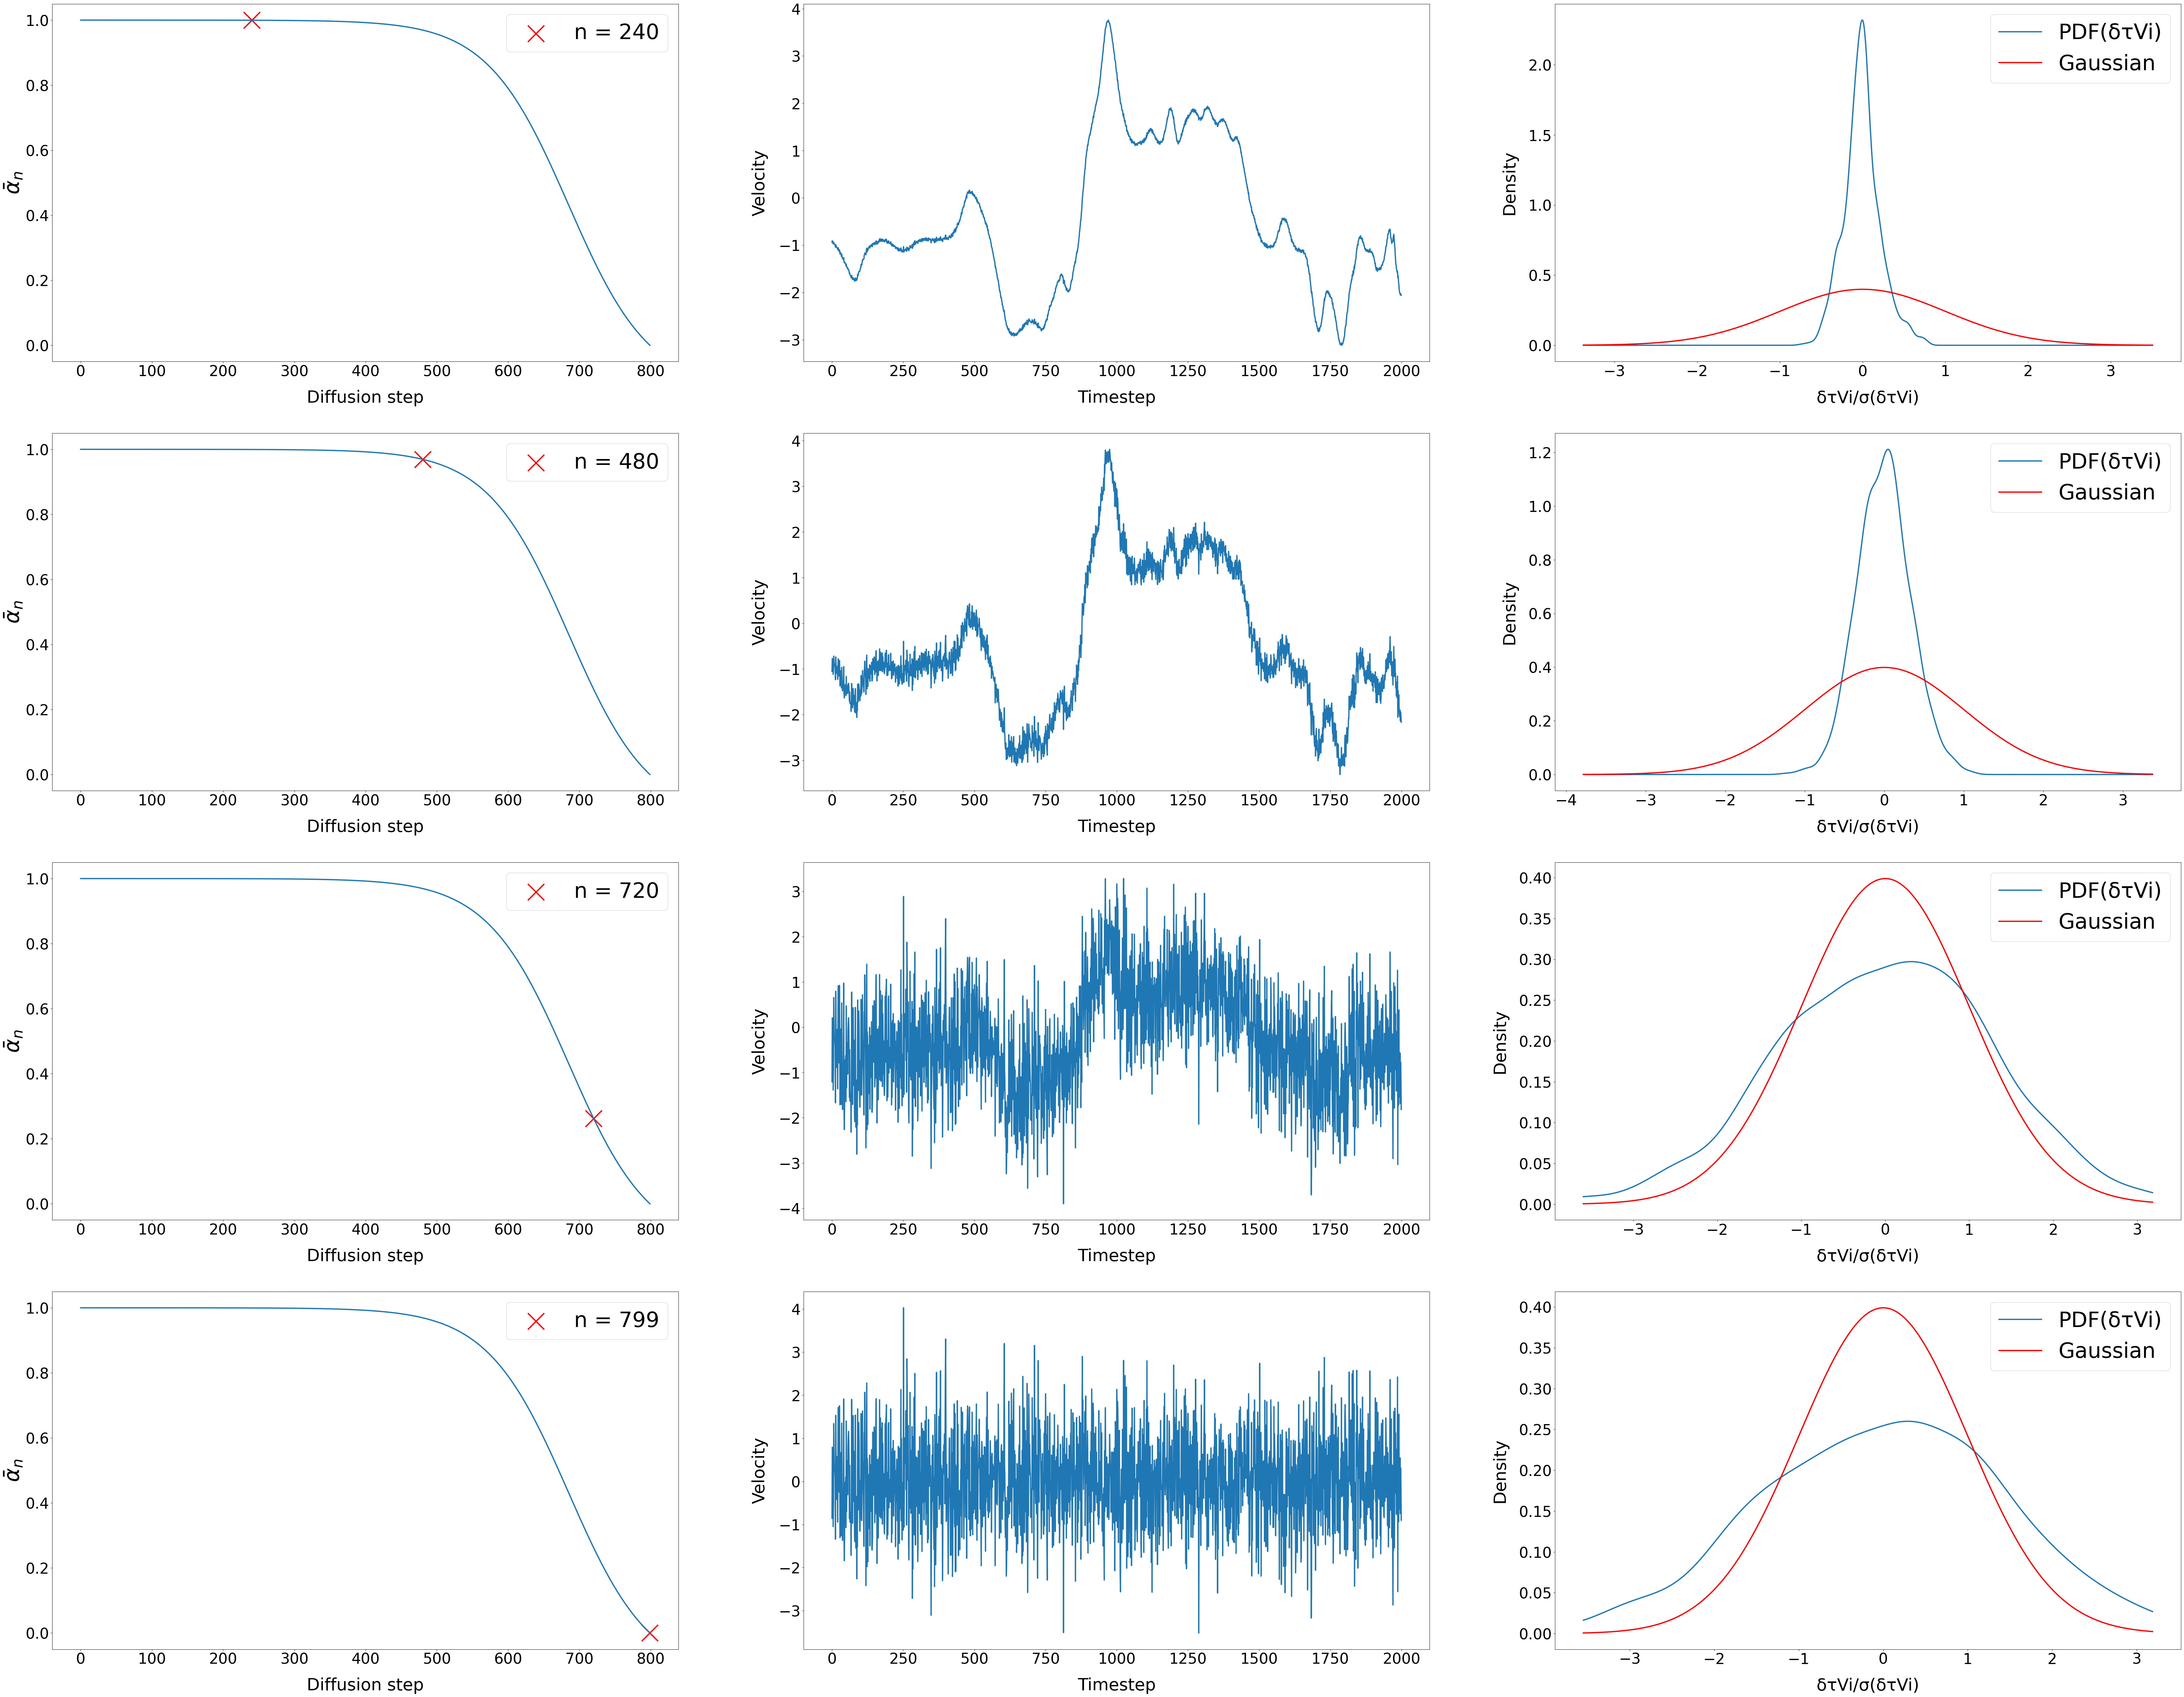

In [164]:
from scipy.stats import norm

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(90,70))

N = 800
noise_schedule = 'tanh6,1'
step_ratio = [0.3, 0.6, 0.9, 1]

betas = get_named_beta_schedule(noise_schedule, N)
alpha_bars = alpha_bar_from_betas(betas)
V0 = velocities_1d[np.random.randint(velocities_1d.shape[0])]
gaussian_noise = np.random.normal(0,1,V0.shape)

for (i,ratio) in enumerate(step_ratio):

    n = min(round(N*ratio), N-1)

    Vn = np.sqrt(alpha_bars[n]) * V0 + np.sqrt(1 - alpha_bars[n]) * gaussian_noise

    # Plot the noise schedule graph with the current alpha bar value
    sns.lineplot(x = np.arange(N),
                 y = alpha_bars,
                 ax=axes[i,0],
                 linewidth=3)
    sns.scatterplot(x = [n],
                    y = alpha_bars[n],
                    marker = 'x',
                    color = 'red',
                    ax=axes[i,0],
                    label=f'n = {n}',
                    s=1500)
    axes[i,0].set_xlabel('Diffusion step', fontsize=40, labelpad=25)
    axes[i,0].set_ylabel(r'$\bar{\alpha}_n$', fontsize=50)
    axes[i,0].tick_params('x', labelsize=35)
    axes[i,0].tick_params('y', labelsize=35)
    axes[i,0].legend(fontsize=50)

    sns.lineplot(x = np.arange(Vn.shape[0]),
                 y = Vn[:,0],
                 ax=axes[i,1],
                 linewidth=3)
    axes[i,1].set_xlabel('Timestep', fontsize=40, labelpad=25)
    axes[i,1].set_ylabel('Velocity', fontsize=40, labelpad=25)
    axes[i,1].tick_params('x', labelsize=35)
    axes[i,1].tick_params('y', labelsize=35)

    increments = velocity_increments(Vn[np.newaxis,:,:], 10)[:,0]
    kde = gaussian_kde(increments)
    std_increments = increments / increments.std()
    x_values = np.linspace(std_increments.min(), std_increments.max(), 1000)
    y_values = kde(x_values)

    sns.lineplot(x = x_values,
                 y = y_values,
                 ax=axes[i,2],
                 linewidth=3,
                 label='PDF(δτVi)')
    gaussian_values = norm.pdf(x_values, loc=0, scale=1)
    sns.lineplot(x = x_values,
                 y = gaussian_values,
                 ax=axes[i,2],
                 linewidth=3,
                 color='red',
                 label='Gaussian')
    axes[i,2].set_xlabel('δτVi/σ(δτVi)', fontsize=40, labelpad=25)
    axes[i,2].set_ylabel('Density', fontsize=40, labelpad=25)
    axes[i,2].tick_params('x', labelsize=35)
    axes[i,2].tick_params('y', labelsize=35)
    axes[i,2].legend(fontsize=50)